# Introduction

This tutorial shows the generation process of the synthetic data and one experiment, as an example of the setup created to study the performance of the proprosed module. Some of the functions used in this file are defined in the helper_functions.py file.

# Imports
Packages (pip freeze) in requirements.txt


In [2]:
%load_ext autoreload
%autoreload 2

# import helper functions to generate graphs and timeseries
from helper_functions import *

# keras
from keras.models import load_model

# z normalization
from sklearn.preprocessing import StandardScaler

# metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# misc
from tqdm.notebook import trange
import matplotlib.pyplot as plt


# Model Architecture

Here we see the model, structure and layers, used in the classification phase

In [8]:
# loading the model and viewing the architecture
model = load_model('model_undirected', compile=False)
# model = load_model('model_directed', compile=False)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 512)               102912    
                                                                 
 dense_71 (Dense)            (None, 256)               131328    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_72 (Dense)            (None, 200)               51400     
                                                                 
 dense_73 (Dense)            (None, 100)               20100     
                                                                 
 dense_74 (Dense)            (None, 1)                 101       
                                                                 
Total params: 305,841
Trainable params: 305,841
Non-t

# Generating timeseries

The generated synthetic data has some variables that need to be defined in order to build the underlying graph (first code cell) and to compose the  time-series (second code cell)

In [9]:
# generating the adjacency matrix
number_of_nodes = 5     # number of nodes of the graph
probability = 0.5       # probability of 2 nodes being connected 
undirected = True       # if graph is directed or undirected
adj = get_adjacency(number_of_nodes, probability, undirected)
print("Adjacency Matrix\n", adj)

# generating the interaction matrix
c = 0.9                 # parameter of laplacian rule
rho = 0.75              # parameter of laplacian rule
A = get_A(adj, c, rho)
print("\nInteraction Matrix\n", A)


Adjacency Matrix
 [[0 0 1 0 0]
 [0 0 0 0 1]
 [1 0 0 0 1]
 [0 0 0 0 1]
 [0 1 1 1 0]]

Interaction Matrix
 [[0.525 0.    0.225 0.    0.   ]
 [0.    0.525 0.    0.    0.225]
 [0.225 0.    0.3   0.    0.225]
 [0.    0.    0.    0.525 0.225]
 [0.    0.225 0.225 0.225 0.075]]


In [18]:
# generating the noise 
number_of_samples = 10000       # number of samples to generate
alpha = 1                       # intensity of diagonal noise
beta = 100                      # intensity of colored noise 
noise = generate_noise(number_of_nodes, number_of_samples, alpha, beta)
print("Noise shape: ", noise.shape)

# generating timeseries
x0 = 0                          # initial value of all nodes 
timeseries = generate_timeseries(A, number_of_samples, x0, noise)
print("Timeseries shape: ", timeseries.shape)

Noise shape:  (10000, 5)
Timeseries shape:  (10000, 5)


# Features

To compute the engineered features we only need the observable time-series (n_observable - number of observable nodes) and the number of lag-moments included in the feature vector. For example, if we define n_features=200, the feature vector will be composed by the 50 first positive and negative correlation lag matrices and their invertions.

In [19]:
n_features = 200 # number of lag moments
n_observable = 4 # number of observable nodes
feature_vector = get_inverted_features(timeseries[:,0:n_observable], n_features)
print("Feature-vector shape (number of node pairs, number of features): ", feature_vector.shape)

# z normalization
scaler = StandardScaler()
feature_vector_ss = scaler.fit_transform(feature_vector)

# predict
preds = model.predict(feature_vector_ss)

# cluster
preds = cluster_predictions(preds, 'kmeans')


Feature-vector shape (number of node pairs, number of features):  (6, 200)
1/1 [==============================] - 0s 16ms/step


# Different Estimators

Here are the state of the art estimators used as references to measure the behaviour of our model

In [26]:
# R1 estimator
r1 = get_r1_preds(timeseries[:,0:n_observable])
print("R1 preds:\t\t", r1)

# R1 - R3 estimator
r1_r3 = get_r1_minus_r3_preds(timeseries[:,0:n_observable])
print("R1 - R3 preds:\t\t", r1_r3)

# Precision Matrix estimator
precision_matrix = get_r0_inv_preds(timeseries[:,0:n_observable])
print("Precision Matrix preds:\t", precision_matrix)

# Granger
granger = get_granger_preds(timeseries[:,0:n_observable])
print("Granger preds:\t\t", granger)

# our method
print("Our method:\t\t", preds)

# Target (Ground truth structure)
As = A[0:n_observable,0:n_observable]
y = get_target(As)
print("\nGround Truth:\t\t", y.squeeze())
y = get_target(A)
print("Ground Truth (all):\t", y.squeeze())

print("\nNote: Connected pairs: 2\tDisconnected pairs: 1")



R1 preds:		 [1 2 1 2 1 2]
R1 - R3 preds:		 [1 1 1 1 1 1]
Precision Matrix preds:	 [1 1 1 1 1 1]
Granger preds:		 [2 2 2 1 1 1]
Our method:		 [1 2 1 1 1 2]

Ground Truth:		 [1 2 1 1 1 1]
Ground Truth (all):	 [1 2 1 1 1 1 2 1 2 2]

Note: Connected pairs: 2	Disconnected pairs: 1


# Multiple Runs: comparing estimators

The next code cell goes through some parameters variation to see its influence on the model performance comparing with the state of the art estimators shown before. In order to obtain more precise performance analysis and smooth out the performance variation for each number of samples, the same test is done nruns times. In each run the number of timeseries samples begins with the value defined by the variable min_size and increases in each step a value defined by the variable step, until it reaches the value defined by the variable max_size. The number of observable nodes is defined as an interval[ss,se], specifying the exact observable ones.

## Run

In [28]:
# number of samples
min_size = 1000
tsize = 200000
max_size= tsize
step = 20000
tssize = np.arange(min_size,max_size,step=step) 
print(tssize)

# graph parameters
sz = 120    # total number of nodes
ss = 0      # observable nodes
se = 30     # observable nodes
c = 0.9
rho = 0.75
p = 0.7
undirected = True

# Define the range of noise variance
qsi = 1
beta = 200
x0 = 0            #Initial condition


# cnn model 
model_cnn = load_model('model_cnn')

# our approach
model = load_model('model_undirected', compile=False)

# number of runs
nruns = 3
comparison_data = np.zeros((len(tssize), nruns, 6, 2))

# run multiple simulations
for i in (t :=  trange(nruns)):
    # generate an A matrix
    adj = get_adjacency(sz, p, undirected)
    A = get_A(adj,c,rho)

    # generate noise
    noise = generate_noise(sz, tsize, qsi, beta) 
    
    # generate the time series
    timeseries = generate_timeseries(A,tsize,x0,noise)

    for j in range(len(tssize)):
        t.set_description(f'Samples {tssize[j]}')
        data_aux=np.copy(timeseries)
        data=data_aux[0:(tssize[j]),ss:se]
        As = A[ss:se,ss:se]

        # features ss
        features_unscaled, y = extract_cross_correlation_unscaled_features(As,data,se-ss, 200)
        features_scaled = normalize_features(features_unscaled, tssize[j])

        # features max
        features_max_cnn = features_unscaled / np.max(features_unscaled)
        features_max_cnn = features_max_cnn.reshape(features_max_cnn.shape[0],features_max_cnn.shape[1],1)
        cnn_preds = model_cnn.predict(features_max_cnn, verbose=0)


        # - - - Our model
        feature_vector = get_inverted_features(data, 200)
        scaler = StandardScaler()
        features_ss = scaler.fit_transform(feature_vector)
        preds = model.predict(features_ss, verbose=0)
        preds = cluster_predictions(preds, method='kmeans')
        comparison_data[j, i, 0, 0] = accuracy_score(y,preds)
        comparison_data[j, i, 0, 1] = balanced_accuracy_score(y,preds)


        # - - - granger 
        preds = get_granger_preds(data, method='gmm')
        acc = accuracy_score(y,preds)
        comparison_data[j, i, 1, 0] = acc
        comparison_data[j, i, 1, 1] = balanced_accuracy_score(y,preds)

        # - - - CNN Max
        preds = cluster_predictions(cnn_preds, method='kmeans')
        acc = accuracy_score(y,preds)
        comparison_data[j, i, 2, 0] = acc
        comparison_data[j, i, 2, 1] = balanced_accuracy_score(y,preds)

        # - - - Precision matrix
        preds = get_r0_inv_preds(data, method='gmm')
        acc = accuracy_score(y,preds)
        comparison_data[j, i, 3, 0] = acc
        comparison_data[j, i, 3, 1] = balanced_accuracy_score(y,preds)

        # - - - R1
        preds = get_r1_preds(data, method='gmm')
        acc = accuracy_score(y,preds)
        comparison_data[j, i, 4, 0] = acc
        comparison_data[j, i, 4, 1] = balanced_accuracy_score(y,preds)

        # - - - R1 - R3
        preds = get_r1_minus_r3_preds(data, method='gmm')
        acc = accuracy_score(y,preds)
        comparison_data[j, i, 5, 0] = acc
        comparison_data[j, i, 5, 1] = balanced_accuracy_score(y,preds)

[  1000  21000  41000  61000  81000 101000 121000 141000 161000 181000]


  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
save = True
if save:
    save_name = f"comparison_data.pkl"
    save_pickle(save_name, comparison_data)

## Plot average over all runs

In this section we plot the data that resulted from the experiment explained before

(10, 6, 2)


SyntaxError: keyword argument repeated: linewidth (2068573817.py, line 20)

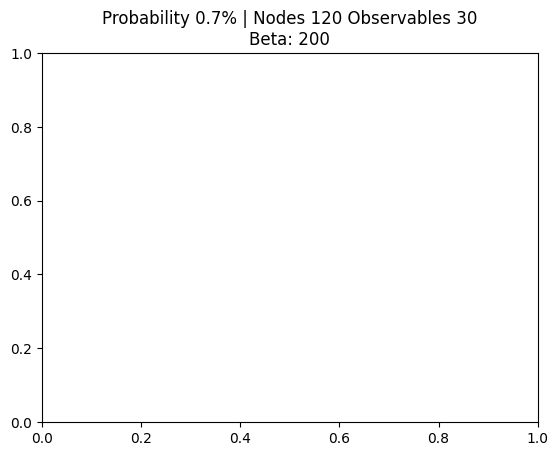

In [33]:
save_name = f"comparison_data.pkl"
data = load_pickles(save_name)

# plotting line styles    
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),]

# average over runs
data_plot = data.mean(axis=1)
print(data_plot.shape)

# metric to plot
metric = 0
metrics = ["Accuracy", "Accuracy balanced"]

# plot
plt.figure()
plt.title(f'Probability {p}% | Nodes {sz} Observables {se}\nBeta: {beta}')
plt.plot(tssize, data_plot[:,0,metric], color='k', linewidth=2.5, label='FFNN with $\mathcal{K}(n)$ (our method)')
plt.plot(tssize, data_plot[:,1,metric], color='orange', linewidth=2.5, label='Granger', ls='--')
plt.plot(tssize, data_plot[:,2,metric], color='green', linewidth=2.5, label='CNN with $\mathcal{F}(n)$ [11]', ls='-.')
plt.plot(tssize, data_plot[:,3,metric], color='red', linewidth=2.5, label='Precision Matrix', ls=':')
plt.plot(tssize, data_plot[:,4,metric], color='purple', linewidth=2.5, label='$R_1$', ls=linestyle_tuple[0][1])
plt.plot(tssize, data_plot[:,5,metric], color='brown', linewidth=2.5, label='$R_1$-$R_3$ (NIG)', ls=linestyle_tuple[1][1])
plt.xlabel('Number of Samples')
plt.ylabel(metrics[metric])  
plt.legend(loc='best', fontsize=10)
